# TinyML - Linear Discriminant Analysis (LDA)

**Author:** Thommas Kevin Sales Flores  
**Institution:** Federal University of Rio Grande do Norte


This notebook demonstrates the complete workflow for training a simple statistical classifier (LDA) in Python and exporting it to run on constrained hardware (Arduino, ESP32, STM32, etc.) using "Bare Metal" C++ (without heavy ML libraries).

The workflow consists of:

- Data Setup: Loading and preparing the Iris Dataset.

- Training: Building the model with Scikit-Learn.

- The Math: Understanding how the decision is actually made.

- Code Generation: Automatically creating a C++ Header File.

- Validation: Verifying the exported logic matches Scikit-Learn.


## 1. Setup and Data Loading
First, we load the classic Iris dataset. It contains 3 classes of flowers and 4 physical features (sensor readings) for each sample.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris

# Configuration to save the file (creates folder if it doesn't exist)
OUTPUT_DIR = "ArduinoCode"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# 1. Load Data
data = load_iris()
X = data.data        # Matrix (150 samples, 4 features)
y = data.target      # Label Vector (0, 1, 2)
target_names = data.target_names

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features.")
print(f"Classes: {target_names}")

Dataset loaded: 150 samples, 4 features.
Classes: ['setosa' 'versicolor' 'virginica']


## 2. Model Training and Visualization
LDA attempts to find linear combinations of features that best separate the classes.

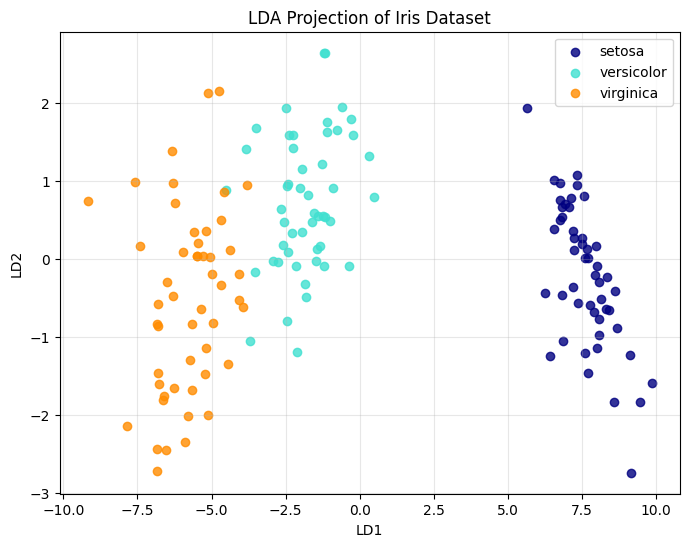

In [4]:
# 2. Train LDA Model
# store_covariance=True is useful for analysis, but for simple inference
# we only need coef_ (weights) and intercept_ (bias).
lda = LinearDiscriminantAnalysis(store_covariance=True)
X_r = lda.fit(X, y).transform(X)

# --- VISUALIZATION (Added for educational purposes) ---
# LDA projects data into a lower-dimensional space (K-1 classes)
plt.figure(figsize=(8, 6))
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA Projection of Iris Dataset')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.grid(True, alpha=0.3)
plt.show()

## 3. The Math Behind Inference (Theory)

To implement this in C++ without libraries, we need to understand exactly what .predict() does under the hood.

LDA calculates a linear score for each class $k$. The "winning" class is simply the one with the highest score.The formula for the score of class $k$ is:

$$Score_k = (\mathbf{w}_k \cdot \mathbf{x}) + b_k$$

Where:

- $\mathbf{x}$: Input vector (sensor readings).

- $\mathbf{w}_k$: Weight vector for class $k$. In scikit-learn, this is model.coef_.

- $b_k$: Bias (or Intercept) value for class $k$. In scikit-learn, this is model.intercept_.

- $\cdot$: Dot Product.T

he final algorithm is a simple Argmax:

$$\text{Final Class} = \underset{k}{\text{argmax}} (Score_k)$$

## 4. C++ Code Generator

This function takes the coef_ and intercept_ arrays from Python and writes a formatted .h file. The generated C++ code implements the dot product described in the formula above.

In [5]:
def generate_header_file(model, output_path):
    """
    Generates a C++ header file containing model weights and an inference function.
    """
    n_features = model.coef_.shape[1]
    n_classes = len(model.classes_)
    
    # Handling binary vs multiclass shapes in scikit-learn
    # Scikit optimizes binary cases by returning only 1 vector.
    # Here, we focus on the generic logic (matrix) for robustness across cases.
    if n_classes == 2:
        print("Warning: Logic optimized for Multiclass. Check coefficients for strict binary cases.")

    with open(output_path, "w") as f:
        # Header Guards (C++ Best Practices)
        f.write("#ifndef LDA_MODEL_H\n")
        f.write("#define LDA_MODEL_H\n\n")
        
        f.write("// ==========================================\n")
        f.write("// Auto-generated LDA Model Parameters\n")
        f.write("// Exported from Python Sklearn\n")
        f.write("// ==========================================\n\n")

        f.write(f"#define NUM_FEATURES {n_features}\n")
        f.write(f"#define NUM_CLASSES {n_classes}\n\n")

        # 1. Writing the Weights Matrix
        f.write("// Weights Matrix (Coefficients): [Classes][Features]\n")
        f.write(f"const float lda_weights[{n_classes}][{n_features}] = {{\n")
        for row in model.coef_:
            # Formatting to 6 decimal places for precision vs size balance
            values = ", ".join([f"{x:.6f}" for x in row])
            f.write(f"    {{ {values} }},\n")
        f.write("};\n\n")

        # 2. Writing the Bias Vector (Intercepts)
        f.write("// Bias Vector (Intercepts): [Classes]\n")
        values = ", ".join([f"{x:.6f}" for x in model.intercept_])
        f.write(f"const float lda_bias[{n_classes}] = {{ {values} }};\n\n")

        # 3. Inline Inference Function
        f.write("// ==========================================\n")
        f.write("// Inference Function (Dot Product + Argmax)\n")
        f.write("// ==========================================\n")
        f.write("""
/**
 * Predicts the class based on sensor features.
 * @param features: Array of floats containing sensor data (size NUM_FEATURES)
 * @return int: The index of the predicted class (0 to NUM_CLASSES-1)
 */
int predictLDA(float *features) {
    int best_class = -1;
    // Initialize with the smallest possible float
    float best_score = -3.4028235E+38; 

    for (int c = 0; c < NUM_CLASSES; c++) {
        // Step 1: Start with the class Bias
        float score = lda_bias[c];

        // Step 2: Dot Product (Feature * Weight)
        for (int f = 0; f < NUM_FEATURES; f++) {
            score += features[f] * lda_weights[c][f];
        }

        // Step 3: Argmax (Keep the highest score)
        if (score > best_score) {
            best_score = score;
            best_class = c;
        }
    }
    return best_class;
}
""")
        f.write("\n#endif // LDA_MODEL_H\n")
    
    print(f"Success! File generated at: '{output_path}'")
    print(f"Model Structure: {n_classes} Classes, {n_features} Features")

# Execute generation
filename = f"{OUTPUT_DIR}/lda_model.h"
generate_header_file(lda, filename)

Success! File generated at: 'ArduinoCode/lda_model.h'
Model Structure: 3 Classes, 4 Features


## 5. Validation and Testing

Before flashing this to an Arduino, let's ensure our mental logic (Score = Weight*X + Bias) matches the Scikit-Learn output exactly.

In [6]:
# Pick a random sample for testing
sample_idx = 100 
sample_data = X[sample_idx]
true_label = y[sample_idx]

# Official Scikit Prediction
sklearn_pred = lda.predict([sample_data])[0]

# Manual Simulation (What the Arduino will do)
scores = []
for i in range(len(lda.classes_)):
    # Score = (Coef * Input) + Intercept
    score = np.dot(sample_data, lda.coef_[i]) + lda.intercept_[i]
    scores.append(score)

my_pred = np.argmax(scores)

print(f"--- Validation ---")
print(f"Input Data: {sample_data}")
print(f"Calculated Scores: {scores}")
print(f"Scikit-Learn Prediction: Class {sklearn_pred} ({target_names[sklearn_pred]})")
print(f"Manual Logic Prediction: Class {my_pred} ({target_names[my_pred]})")

if sklearn_pred == my_pred:
    print("\n✅ Export logic is consistent!")
else:
    print("\n❌ Calculation divergence detected.")

--- Validation ---
Input Data: [6.3 3.3 6.  2.5]
Calculated Scores: [-89.23879612911925, 9.720982793758584, 28.480315715231704]
Scikit-Learn Prediction: Class 2 (virginica)
Manual Logic Prediction: Class 2 (virginica)

✅ Export logic is consistent!
